In [129]:
import pandas as pd
import json
import sklearn

In [130]:
# Load cleaned charging data
charging_data: pd.DataFrame = pd.read_pickle('data/charging_modified.pkl')

# Print head
charging_data.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,userID,NoChargingTime,...,kWhPerMinute,month,user_paymentRequired_values,user_userID,user_requestedDeparture,user_modifiedAt,user_minutesAvailable,user_milesRequested,user_kWhRequested,user_WhPerMile
Index,,,,,,,,,,,,,,,,,,,,,
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1,AG-3F30,1-1-179-810,194.0,0 days 01:39:40,...,0.095233,1,True,194.0,"Thu, 02 Jan 2020 20:51:54 GMT","Thu, 02 Jan 2020 13:09:39 GMT",463.0,100.0,25.0,250.0
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1,AG-1F01,1-1-193-825,4275.0,0 days 02:20:16,...,0.082485,1,True,4275.0,"Thu, 02 Jan 2020 23:31:50 GMT","Thu, 02 Jan 2020 13:37:11 GMT",595.0,250.0,70.0,280.0
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1,AG-1F03,1-1-193-829,344.0,0 days 08:04:16,...,0.041138,1,True,344.0,"Thu, 02 Jan 2020 14:56:35 GMT","Thu, 02 Jan 2020 13:57:17 GMT",60.0,20.0,8.0,400.0
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1,AG-1F04,1-1-193-820,1117.0,0 days 01:19:54,...,0.029892,1,True,1117.0,"Thu, 02 Jan 2020 15:04:58 GMT","Thu, 02 Jan 2020 14:00:03 GMT",65.0,20.0,8.0,400.0
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1,AG-1F06,1-1-193-819,334.0,0 days 03:51:10,...,0.051945,1,True,334.0,"Thu, 02 Jan 2020 22:24:01 GMT","Thu, 02 Jan 2020 14:00:13 GMT",504.0,40.0,16.0,400.0


In [131]:
# Print rows with null values
charging_data[charging_data.isnull().values.any(axis=1)]

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,userID,NoChargingTime,...,kWhPerMinute,month,user_paymentRequired_values,user_userID,user_requestedDeparture,user_modifiedAt,user_minutesAvailable,user_milesRequested,user_kWhRequested,user_WhPerMile
Index,,,,,,,,,,,,,,,,,,,,,
11,5e23b149f9af8b5fe4b973da,2020-01-02 15:04:38+00:00,2020-01-02 23:33:26+00:00,2020-01-02 22:48:48+00:00,0.812,1,AG-1F14,1-1-194-818,nan,0 days 00:44:38,...,0.001749,1,None,NaN,None,None,NaN,NaN,NaN,NaN
41,5e23b149f9af8b5fe4b973f8,2020-01-02 17:21:05+00:00,2020-01-02 20:10:40+00:00,2020-01-02 19:59:39+00:00,0.852,1,AG-4F50,1-1-191-782,nan,0 days 00:11:01,...,0.005373,1,None,NaN,None,None,NaN,NaN,NaN,NaN
180,5e2a48e8f9af8b75aed8e941,2020-01-07 14:31:09+00:00,2020-01-08 00:46:30+00:00,2020-01-07 15:07:06+00:00,0.847,1,AG-3F32,1-1-179-800,nan,0 days 09:39:24,...,0.023561,1,None,NaN,None,None,NaN,NaN,NaN,NaN
193,5e2a48e8f9af8b75aed8e94e,2020-01-07 15:00:25+00:00,2020-01-07 23:30:37+00:00,2020-01-07 22:54:11+00:00,0.735,1,AG-3F17,1-1-179-779,nan,0 days 00:36:26,...,0.001551,1,None,NaN,None,None,NaN,NaN,NaN,NaN
265,5e2b9a62f9af8b7d745b131d,2020-01-08 15:01:52+00:00,2020-01-08 19:01:39+00:00,2020-01-08 16:33:58+00:00,0.769,1,AG-3F21,1-1-179-801,nan,0 days 02:27:41,...,0.008350,1,None,NaN,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,5d54a7cff9af8b413ec70556,2019-07-29 13:46:52+00:00,2019-07-30 00:18:54+00:00,2019-07-30 00:08:24+00:00,1.489,1,AG-3F32,1-1-179-800,nan,0 days 00:10:30,...,0.002396,7,None,NaN,None,None,NaN,NaN,NaN,NaN
9954,5d54a7cff9af8b413ec70583,2019-07-30 00:33:36+00:00,2019-07-30 00:56:04+00:00,2019-07-30 00:57:03+00:00,0.617,1,AG-1F05,1-1-193-816,nan,-1 days +23:59:01,...,0.026311,7,None,NaN,None,None,NaN,NaN,NaN,NaN
9959,5d55f950f9af8b45dfb3d876,2019-07-30 12:32:29+00:00,2019-07-31 01:55:43+00:00,2019-07-31 01:07:04+00:00,1.912,1,AG-1F01,1-1-193-825,nan,0 days 00:48:39,...,0.002534,7,None,NaN,None,None,NaN,NaN,NaN,NaN


In [132]:
# Delete rows with null values
charging_data = charging_data.dropna()

In [133]:
# Drop unnecessary columns
prepared_data = charging_data.drop(columns=['id', 'ChargingTime', 'NoChargingTime', 'user_modifiedAt'])
prepared_data.head()

# Convert string dates to numeric timestamps
date_colum_names = ['connectionTime', 'disconnectTime', 'doneChargingTime', 'user_requestedDeparture']
for date_column_name in date_colum_names:
    prepared_data[date_column_name] = pd.to_datetime(prepared_data[date_column_name]).values.astype(float)

# Hot encode categorical columns
categorical_columns = ['spaceID', 'stationID']
prepared_data = prepared_data.astype({
    'spaceID': 'category',
    'stationID': 'category',
    'siteID': 'int64',
    'userID': 'float64',
})

prepared_data = prepared_data.astype({
    'userID': 'int64'
})

prepared_data = pd.get_dummies(prepared_data, columns=categorical_columns)

# Print types
prepared_data.dtypes

connectionTime           float64
disconnectTime           float64
doneChargingTime         float64
kWhDelivered             float64
siteID                     int64
                          ...   
stationID_2-39-91-441       bool
stationID_2-39-92-436       bool
stationID_2-39-92-442       bool
stationID_2-39-95-27        bool
stationID_2-39-95-444       bool
Length: 227, dtype: object

In [134]:
def kmean(data, n_clusters):
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(data)
    return labels, kmeans, pca_result

def pca(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    return pca_result

def pca_based_kmean(data, n_clusters):
    pca_result = pca(data)
    labels, kmeans, pca_result = kmean(pca_result, n_clusters)
    return labels, kmeans, pca_result

In [135]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kmeans(data, labels):
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(data[labels == i, 0], data[labels == i, 1], label=f'Cluster {i}')
    plt.legend()
    plt.show() 
    
def perform_kmeans_and_plot(data, n_clusters):
    labels, kmeans, pca_result = pca_based_kmean(data, n_clusters)
    plot_kmeans(pca_result, labels)
    return labels, kmeans, pca_result

## Clustering the whole data

C:\Users\Administrator\Desktop\Uni\AA_Team_9_WS23\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Administrator\Desktop\Uni\AA_Team_9_WS23\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Administrator\Desktop\Uni\AA_Team_9_WS23\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Administrator\Desktop\Uni\AA_Team_9_WS23\venv\Lib\site-packages\sklearn\clus

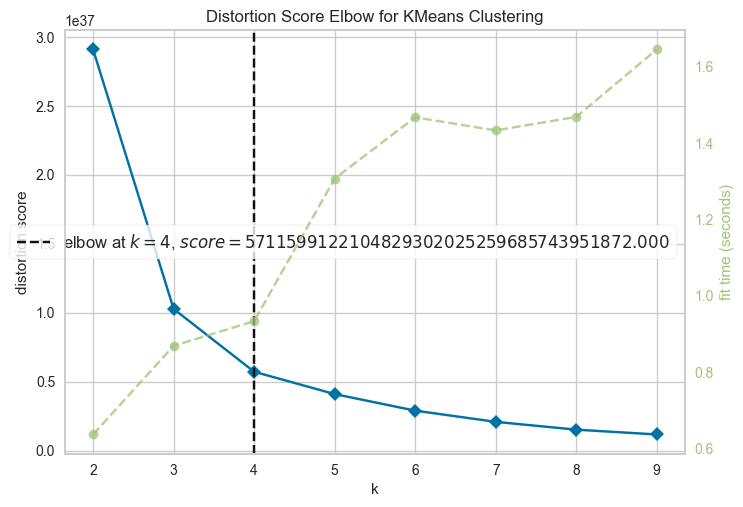

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(2, 10))

In [136]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

# Find the best number of clusters via elbow method
kelbow_visualizer(KMeans(random_state=42, init='k-means++'), prepared_data, k=(2,10))

In [137]:
number_of_clusters = 4

C:\Users\Administrator\Desktop\Uni\AA_Team_9_WS23\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


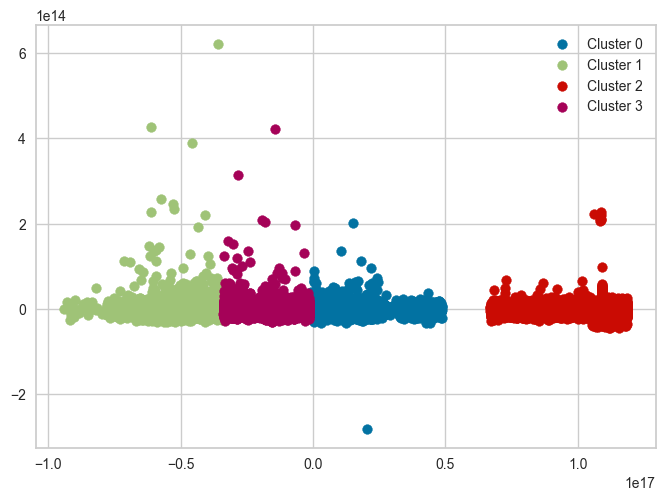

connectionTime                                            \
                 count          mean           std           min   
cluster                                                            
0              10775.0  1.579704e+18  6.039995e+15  1.571510e+18   
1              12893.0  1.547235e+18  4.960230e+15  1.525101e+18   
2               7666.0  1.620716e+18  7.283070e+15  1.605733e+18   
3              14674.0  1.563337e+18  4.604571e+15  1.555289e+18   

                                                                 \
                  25%           50%           75%           max   
cluster                                                           
0        1.574718e+18  1.579105e+18  1.582644e+18  1.596492e+18   
1        1.543252e+18  1.547649e+18  1.551460e+18  1.555279e+18   
2        1.614979e+18  1.621361e+18  1.626977e+18  1.631598e+18   
3        1.559313e+18  1.563459e+18  1.567054e+18  1.571516e+18   

        disconnectTime                ... user_kWhRequested          \
                 count          mean  ...               75%     max   
cluster                               ...                             
0              10775.0  1.579728e+18  ...              32.5  180.00   
1              12893.0  1.547260e+18  ...              30.0  180.00   
2               7666.0  1.620736e+18  ...              32.0  215.32   
3              14674.0  1.563362e+18  ...              30.0  180.00   

        user_WhPerMile                                                      \
                 count        mean         std    min    25%    50%    75%   
cluster                                                                      
0              10775.0  380.946079   89.677864  200.0  325.0  400.0  400.0   
1              12893.0  363.887226   96.656341  200.0  292.0  375.0  400.0   
2               7666.0  321.635142  116.610290   50.0  279.0  300.0  350.0   
3              14674.0  369.507496  102.051521  200.0  300.0  375.0  400.0   

                 
            max  
cluster          
0         630.0  
1         600.0  
2        2000.0  
3         600.0  

[4 rows x 128 columns]

In [138]:
labels, kmeans, pca_result = perform_kmeans_and_plot(prepared_data, number_of_clusters)

# Group the data by cluster
clustered_data = prepared_data.copy()
clustered_data['cluster'] = labels
clustered_data = clustered_data.groupby('cluster')
clustered_data.describe()

Our initial idea was that `sideID` might have a big influence on the clustering result, so we run the clustering without it again

C:\Users\Administrator\Desktop\Uni\AA_Team_9_WS23\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


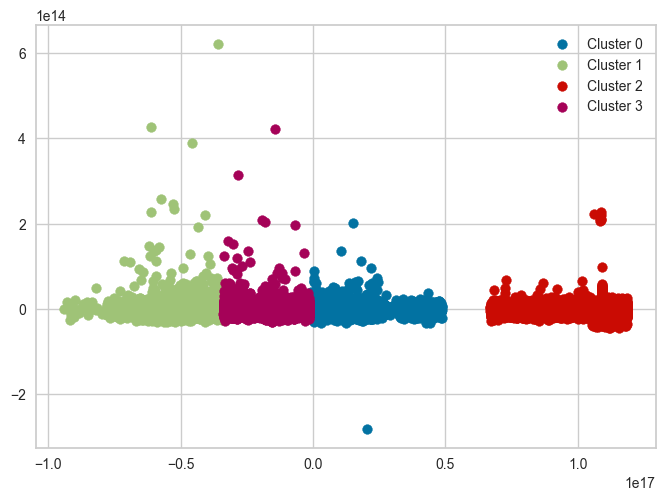

In [139]:
data_without_sideId = prepared_data.copy()
data_without_sideId = data_without_sideId.drop(columns=['siteID'])

labels, kmeans, pca_result = perform_kmeans_and_plot(data_without_sideId, number_of_clusters)